# k-NN Algorithm

My implementation of the k-Nearest Neighbours Algorithm

In [1]:
%matplotlib inline
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import operator
import random

# Load the IRIS dataset
iris = datasets.load_iris()

#view a description of the dataset (uncomment next line to do so)
#print(iris.DESCR)

#Set X equal to features, Y equal to the targets
X=iris.data 
y=iris.target 

mySeed=1234567

## 1. Exploratory Data Analysis



In [2]:
def myplotGrid(X, y):
    
    n_features = len(X[0])
    features = ['sepal length', 'sepal width', 'petal length', 'petal width']
    count = 1

    fig = plt.figure(figsize=(11, 11))

    for i in range(n_features):
        for j in range (n_features):

            ax = fig.add_subplot(n_features, n_features, count)

            if i == j:
                ax.hist(X[:, i], color = 'lightseagreen')

            else:
                ax.scatter(X[:, i], X[:, j], c = y, s=15, cmap = plt.cm.Set3)

            if i==n_features-1:
                ax.set_xlabel(features[j])
            if j==0:
                ax.set_ylabel(features[i])

            count+=1

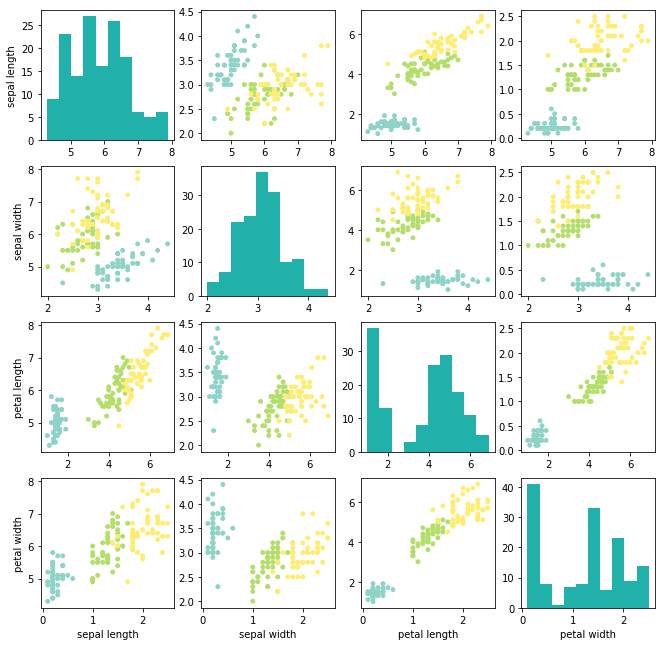

In [3]:
myplotGrid(X, y)

### 1.2. Exploratory Data Analysis under noise

I am going to perturb the data with some Gaussian noise,

    np.random.seed(mySeed) # initialize random seed to replicate results over different runs
    XN=X+np.random.normal(0,0.5,X.shape)
    
and then invoke the plot function

    myplotGrid(XN,y)

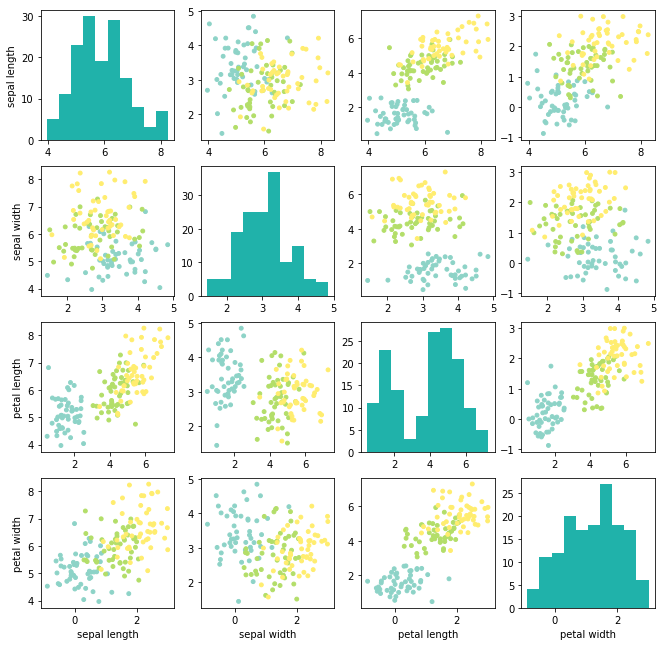

In [4]:
np.random.seed(mySeed) # initialize random seed to replicate results over different runs
XN = X + np.random.normal(0, 0.5, X.shape)

myplotGrid(XN, y)

## 2. Implementing kNN

### 2.1 Distance Metrics

* `minkowski_distance:` Minkowsky distance `(default)`
* `euclidean_distance:` (Minkowsky distance with p=2)
* `manhattan_distance:` (Minkowsky distance with p=1)
* `chebyshev_distance:` Chebyshev distance
* `hassanat_distance:` Hassanat distance

In [5]:
def minkowski_distance(in1, in2, p): # euclidean distance with p=2 and manhattan distance with p=1
    dist = 0
    for x1, x2 in zip(in1, in2):
        dist += pow(abs(x1 - x2), p)
    return pow(dist, 1 / p)


def chebyshev_distance(in1, in2):
    dist = []
    for x1, x2 in zip(in1, in2):
        dist.append(abs(x1 - x2))

    return max(dist)


def hassanat_distance(in1, in2):
    dist = 0
    for x1, x2 in zip(in1, in2):
        if min([x1, x2]) >= 0:
            
            dist += 1 - ( (1 + min([x1, x2])) ) / (1 + max([x1, x2]))
        else:
            dist += 1 - ( (1 + min([x1, x2]) + abs(min([x1, x2]))) ) / (1 + max([x1, x2]) + abs(min([x1, x2])) )
    return dist


### 2.2 Finding the Nearest Neighbours

In [6]:
def get_neighbours(x_, X, n_neighbours, metric, p):

    distances = []
    if metric == 'euclidean':
        for i in range(len(X)):
            distances.append((minkowski_distance(x_, X[i], 2), i))
    elif metric == 'manhattan':
        for i in range(len(X)):
            distances.append((minkowski_distance(x_, X[i], 1), i))
    elif metric == 'hassanat':
        for i in range(len(X)):
            distances.append((hassanat_distance(x_, X[i]), i))
    elif metric == 'chebyshev':
        for i in range(len(X)):
            distances.append((chebyshev_distance(x_, X[i]), i))
    else:
        for i in range(len(X)):
            distances.append((minkowski_distance(x_, X[i], p), i))

    distances = sorted(distances, key=operator.itemgetter(0))  # 0 is the distance, first item of the tuple
    
    neighbours = []
    neighbours_distances = []
    for i in range(n_neighbours):
        neighbours.append(distances[i][1])
        neighbours_distances.append(distances[i][0])
        
    return neighbours, neighbours_distances


### 2.3 Calculating the modes

* `distance:` Weight points by the inverse of their distance.
* `uniform:` Uniform weights. All points are weighted equally. (`default`)

In [7]:
def get_weighted_modes(labels, weights_method, neighbours_distances):
    
    if weights_method == 'distance':
        weights = [(1/d) for d in neighbours_distances]
    else:
        weights = np.ones(len(neighbours_distances)) # default: uniform
                      
    classes, indices = np.unique(labels, return_inverse=True)
    counts = np.zeros(classes.shape) 
    
    for c, w in zip(indices, weights):
        counts[c] += w

    return np.argwhere(counts == np.amax(counts)).flatten().tolist()
   

### 2.4 Tie Breking Methods

* `smallest:` Pick the smallest index among tied groups `(default)`
* `random:` Randomly pick a class among tied groups
* `nearest:` Pick the class with the nearest neighbour among tied groups

In [8]:
def break_tie(breaktie_metric, labels, indices):

    if breaktie_metric == 'random':
        label = random.choice(labels)
        return label

    elif breaktie_metric == 'nearest':
        for i in indices:
            if i in labels:
                return i
    else:
        return labels[0] # default: smallest
    

### 2.5 Assigning the Labels

In [9]:
def assign_label(labels, breaktie_metric, modes):

    classes, indices = np.unique(labels, return_inverse=True)
    
    if len(modes) > 1:
        label = classes[break_tie(breaktie_metric, modes, labels)]
    else:
        label = classes[modes[0]]
    return label

### 2.6 mykNN Function

In [10]:
def mykNN(X, y, X_,
          n_neighbours=5,
          distance_metric='minkowski', 
          p=2,           
          breaktie_metric='smallest',
          weights_method='uniform'):
    
    pred = []
    
    for i, x_ in enumerate(X_):
        
        neighbours, neighbours_distances = get_neighbours(x_, X, n_neighbours, distance_metric, p)
        labels = y[neighbours]
        
        modes = get_weighted_modes(labels, weights_method, neighbours_distances)
        pred.append(assign_label(labels, breaktie_metric, modes))  
        
    return pred

## 3. Custom Functions for Evaluation

In [11]:
# =============================================================================
# Precision = tp/tp+fp
# Recall = tp/tp+fn
# Specificity (to a class) = tn/tn+fp
# =============================================================================

def myConfMat(y_test, y_pred):
    
    classno = len(np.unique(y_test))
    
    # initialize the confusion matrix to zeros
    C = np.zeros([classno, classno]) 
    
    #loop through all results and update the confusion matrix
    for t, p in zip(y_test, y_pred): 
        C[t][p] += 1
        
    return C


def myAccuracy(y_test, y_pred):
    
    return len(np.where(y_test == y_pred)[0]) / len(y_pred)


def myPrecision(y_test, y_pred):
    
    classes = np.unique(y_pred)
    matrix = myConfMat(y_test, y_pred)
    
    tp = [matrix[i][i] for i in classes]
    p = [sum(matrix[:, i]) for i in classes]
    
    precision = [tp[i] / p[i] for i in classes]
    return precision


def myRecall(y_test, y_pred):
    
    classes = np.unique(y_pred)
    matrix = myConfMat(y_test, y_pred)
    
    tp = [matrix[i][i] for i in classes]
    tp_fn = [sum(matrix[i]) for i in classes]
    
    recall = [tp[i] / tp_fn[i] for i in classes]
    return recall


### 4. Nested Cross-validation using KNN


In [16]:
def myNestedCrossVal(X, y, foldK, nns, mySeed, dists, breaktie_metric, weights_method):
    
    np.random.seed(mySeed)
    accuracy_fold = []
    matrices = []
    
    # generate a list of shuffled indices from in the range (0, number of data)
    indices = list(range(X.shape[0]))
    indices = np.random.permutation(indices)
    
    
    # split the indices to foldK different bins (here, 5)
    bins = np.array_split(indices, foldK)
    
    assert(foldK == len(bins))
    
    # loop through folds
    for i in range(foldK):
        
        print('\n\n'+'-'*45, 'Fold ', i+1, '-'*45,)
        
        foldTrain = [] # list to save current indices for training
        foldTest = []  # list to save current indices for testing
        foldVal = []   # list to save current indices for validation

        # loop through all bins, take bin i for testing, the next bin for validation, and the rest for training
        for j in range(0, len(bins)):
            if j == i:
                foldTest.extend(bins[j])
                
            elif j == (i+1)%foldK:
                foldVal.extend(bins[j])
            else:
                foldTrain.extend(bins[j])

        assert not np.intersect1d(foldTest, foldVal).size
        assert not np.intersect1d(foldTrain, foldTest).size
        assert not np.intersect1d(foldTrain, foldVal).size
       
        bestDistance = ''  # save the best distance metric here
        bestNN = -1  # save the best number of neighbours here
        bestAccuracy = - 10  # save the best attained accuracy here (in terms of validation)
        bestTieBreaker = ''  # save the best break tie metric here
        bestWeights = ''  # save the best weight metric here
        
        # loop through all parameters
        for d in dists:
            for n in nns:
                for bt in breaktie_metric:
                    for w in weights_method:
                
                        y_pred = mykNN(X[foldTrain], y[foldTrain], X[foldVal], n, distance_metric=d,
                                      breaktie_metric=bt, weights_method=w)
                        
                        current_accuracy = myAccuracy(y[foldVal], y_pred)
                        
                        print('NN: {:5} |    Dist: {:12} |    BreakTie: {:12} |    Weights: {:12}'.format(n,
                                                d, bt, w), '|    Acc: {0:.2f}'.format(current_accuracy) )

                        # save parameters if results are the best we had
                        if current_accuracy > bestAccuracy:
                            bestDistance = d
                            bestNN = n
                            bestTieBreaker = bt
                            bestWeights = w
                            bestAccuracy = current_accuracy
                            
                        

        print('\n', '='*40, 'End of Val for Fold', i+1, '='*40,)
        print('Best NN:', bestNN, ' |  Best Distance:', bestDistance,
              '|  Best Tie Breaker:', bestTieBreaker, ' |  Best Weights:', bestWeights)
        
        
        # evaluate on test data:
        # extend your training set by including the validation set
        foldTrain.extend(foldVal)
    
        assert not np.intersect1d(foldTrain, foldTest).size
        
        y_pred = mykNN(X[foldTrain], y[foldTrain], X[foldTest], bestNN, distance_metric=bestDistance,
                      breaktie_metric=bestTieBreaker, weights_method=bestWeights)

        print(y_pred, '\n', y[foldTest])
        
        accuracy = myAccuracy(y[foldTest], y_pred)
        precision = myPrecision(y[foldTest], y_pred)
        recall = myRecall(y[foldTest], y_pred)
        cm = myConfMat(y[foldTest], y_pred)
        matrices.append(cm)
        
        # get performance on fold, save result in accuracy_fold array
        accuracy_fold.append(accuracy)
        
        print('\n\n', '-'*34, 'Test Results for Fold', i+1, '-'*34,)
        print(' '*40, [r for r in cm[0]])
        print(' '*40, [r for r in cm[1]])
        print(' '*40, [r for r in cm[2]])
        print('\naccuracy: ', accuracy)
        print('precision: ', precision, '       |        recall:    ', recall)
       
    print('\n', '='*45, 'Final Results', '='*45,)
    print('\nmean: ', np.mean(accuracy_fold), '       |        std:    ', np.std(accuracy_fold))
    print(np.sum(matrices, axis=0))
    
    return accuracy_fold


### 5. Results
---

In [20]:
foldK = 5
nns = range(1, 11)
distances = ['euclidean', 'chebyshev', 'hassanat', 'manhattan']
breaktie_metric = ['smallest','nearest',  'random']
weights_method=['distance', 'uniform']


print(myNestedCrossVal(X, y, foldK, nns, mySeed, distances, breaktie_metric, weights_method))
breaktie_metric = ['random','nearest',  'smallest']
distances = ['chebyshev', 'hassanat','euclidean', 'manhattan']
print(myNestedCrossVal(XN, y, foldK, nns, mySeed, distances, breaktie_metric, weights_method))



--------------------------------------------- Fold  1 ---------------------------------------------
NN:     1 |    Dist: euclidean    |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.93
NN:     1 |    Dist: euclidean    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.93
NN:     1 |    Dist: euclidean    |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.93
NN:     1 |    Dist: euclidean    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.93
NN:     1 |    Dist: euclidean    |    BreakTie: random       |    Weights: distance     |    Acc: 0.93
NN:     1 |    Dist: euclidean    |    BreakTie: random       |    Weights: uniform      |    Acc: 0.93
NN:     2 |    Dist: euclidean    |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.93
NN:     2 |    Dist: euclidean    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.93
NN:     2 |    Dist: euclidean    |    BreakTie: nearest      |   

NN:     4 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.97
NN:     4 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.97
NN:     4 |    Dist: chebyshev    |    BreakTie: random       |    Weights: distance     |    Acc: 0.97
NN:     4 |    Dist: chebyshev    |    BreakTie: random       |    Weights: uniform      |    Acc: 0.97
NN:     5 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.97
NN:     5 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.97
NN:     5 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.97
NN:     5 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.97
NN:     5 |    Dist: chebyshev    |    BreakTie: random       |    Weights: distance     |    Acc: 0.97
NN:     5 |    Dist: chebyshev    |    BreakTie: random       | 

NN:     7 |    Dist: hassanat     |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.93
NN:     7 |    Dist: hassanat     |    BreakTie: random       |    Weights: distance     |    Acc: 0.93
NN:     7 |    Dist: hassanat     |    BreakTie: random       |    Weights: uniform      |    Acc: 0.93
NN:     8 |    Dist: hassanat     |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.90
NN:     8 |    Dist: hassanat     |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.90
NN:     8 |    Dist: hassanat     |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.90
NN:     8 |    Dist: hassanat     |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.93
NN:     8 |    Dist: hassanat     |    BreakTie: random       |    Weights: distance     |    Acc: 0.90
NN:     8 |    Dist: hassanat     |    BreakTie: random       |    Weights: uniform      |    Acc: 0.90
NN:     9 |    Dist: hassanat     |    BreakTie: smallest     | 

NN:     2 |    Dist: euclidean    |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.93
NN:     2 |    Dist: euclidean    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.97
NN:     2 |    Dist: euclidean    |    BreakTie: random       |    Weights: distance     |    Acc: 0.93
NN:     2 |    Dist: euclidean    |    BreakTie: random       |    Weights: uniform      |    Acc: 0.93
NN:     3 |    Dist: euclidean    |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.97
NN:     3 |    Dist: euclidean    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.97
NN:     3 |    Dist: euclidean    |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.97
NN:     3 |    Dist: euclidean    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.97
NN:     3 |    Dist: euclidean    |    BreakTie: random       |    Weights: distance     |    Acc: 0.97
NN:     3 |    Dist: euclidean    |    BreakTie: random       | 

NN:     6 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.97
NN:     6 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 1.00
NN:     6 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.97
NN:     6 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.97
NN:     6 |    Dist: chebyshev    |    BreakTie: random       |    Weights: distance     |    Acc: 0.97
NN:     6 |    Dist: chebyshev    |    BreakTie: random       |    Weights: uniform      |    Acc: 1.00
NN:     7 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: distance     |    Acc: 1.00
NN:     7 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 1.00
NN:     7 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: distance     |    Acc: 1.00
NN:     7 |    Dist: chebyshev    |    BreakTie: nearest      | 

NN:     9 |    Dist: hassanat     |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.97
NN:     9 |    Dist: hassanat     |    BreakTie: random       |    Weights: distance     |    Acc: 0.97
NN:     9 |    Dist: hassanat     |    BreakTie: random       |    Weights: uniform      |    Acc: 0.97
NN:    10 |    Dist: hassanat     |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.93
NN:    10 |    Dist: hassanat     |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.93
NN:    10 |    Dist: hassanat     |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.93
NN:    10 |    Dist: hassanat     |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.97
NN:    10 |    Dist: hassanat     |    BreakTie: random       |    Weights: distance     |    Acc: 0.93
NN:    10 |    Dist: hassanat     |    BreakTie: random       |    Weights: uniform      |    Acc: 0.97
NN:     1 |    Dist: manhattan    |    BreakTie: smallest     | 

NN:     2 |    Dist: euclidean    |    BreakTie: nearest      |    Weights: distance     |    Acc: 1.00
NN:     2 |    Dist: euclidean    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 1.00
NN:     2 |    Dist: euclidean    |    BreakTie: random       |    Weights: distance     |    Acc: 1.00
NN:     2 |    Dist: euclidean    |    BreakTie: random       |    Weights: uniform      |    Acc: 1.00
NN:     3 |    Dist: euclidean    |    BreakTie: smallest     |    Weights: distance     |    Acc: 1.00
NN:     3 |    Dist: euclidean    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 1.00
NN:     3 |    Dist: euclidean    |    BreakTie: nearest      |    Weights: distance     |    Acc: 1.00
NN:     3 |    Dist: euclidean    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 1.00
NN:     3 |    Dist: euclidean    |    BreakTie: random       |    Weights: distance     |    Acc: 1.00
NN:     3 |    Dist: euclidean    |    BreakTie: random       | 

NN:     5 |    Dist: chebyshev    |    BreakTie: random       |    Weights: distance     |    Acc: 1.00
NN:     5 |    Dist: chebyshev    |    BreakTie: random       |    Weights: uniform      |    Acc: 1.00
NN:     6 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: distance     |    Acc: 1.00
NN:     6 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.97
NN:     6 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: distance     |    Acc: 1.00
NN:     6 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 1.00
NN:     6 |    Dist: chebyshev    |    BreakTie: random       |    Weights: distance     |    Acc: 1.00
NN:     6 |    Dist: chebyshev    |    BreakTie: random       |    Weights: uniform      |    Acc: 0.97
NN:     7 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: distance     |    Acc: 1.00
NN:     7 |    Dist: chebyshev    |    BreakTie: smallest     | 

NN:     9 |    Dist: hassanat     |    BreakTie: nearest      |    Weights: uniform      |    Acc: 1.00
NN:     9 |    Dist: hassanat     |    BreakTie: random       |    Weights: distance     |    Acc: 1.00
NN:     9 |    Dist: hassanat     |    BreakTie: random       |    Weights: uniform      |    Acc: 1.00
NN:    10 |    Dist: hassanat     |    BreakTie: smallest     |    Weights: distance     |    Acc: 1.00
NN:    10 |    Dist: hassanat     |    BreakTie: smallest     |    Weights: uniform      |    Acc: 1.00
NN:    10 |    Dist: hassanat     |    BreakTie: nearest      |    Weights: distance     |    Acc: 1.00
NN:    10 |    Dist: hassanat     |    BreakTie: nearest      |    Weights: uniform      |    Acc: 1.00
NN:    10 |    Dist: hassanat     |    BreakTie: random       |    Weights: distance     |    Acc: 1.00
NN:    10 |    Dist: hassanat     |    BreakTie: random       |    Weights: uniform      |    Acc: 1.00
NN:     1 |    Dist: manhattan    |    BreakTie: smallest     | 

NN:     3 |    Dist: euclidean    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.97
NN:     3 |    Dist: euclidean    |    BreakTie: random       |    Weights: distance     |    Acc: 0.97
NN:     3 |    Dist: euclidean    |    BreakTie: random       |    Weights: uniform      |    Acc: 0.97
NN:     4 |    Dist: euclidean    |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.97
NN:     4 |    Dist: euclidean    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 1.00
NN:     4 |    Dist: euclidean    |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.97
NN:     4 |    Dist: euclidean    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.97
NN:     4 |    Dist: euclidean    |    BreakTie: random       |    Weights: distance     |    Acc: 0.97
NN:     4 |    Dist: euclidean    |    BreakTie: random       |    Weights: uniform      |    Acc: 0.97
NN:     5 |    Dist: euclidean    |    BreakTie: smallest     | 

NN:     8 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.97
NN:     8 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.97
NN:     8 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.97
NN:     8 |    Dist: chebyshev    |    BreakTie: random       |    Weights: distance     |    Acc: 0.97
NN:     8 |    Dist: chebyshev    |    BreakTie: random       |    Weights: uniform      |    Acc: 0.93
NN:     9 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.97
NN:     9 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.97
NN:     9 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: distance     |    Acc: 1.00
NN:     9 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.97
NN:     9 |    Dist: chebyshev    |    BreakTie: random       | 

NN:     1 |    Dist: manhattan    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.97
NN:     1 |    Dist: manhattan    |    BreakTie: random       |    Weights: distance     |    Acc: 0.97
NN:     1 |    Dist: manhattan    |    BreakTie: random       |    Weights: uniform      |    Acc: 0.97
NN:     2 |    Dist: manhattan    |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.97
NN:     2 |    Dist: manhattan    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.97
NN:     2 |    Dist: manhattan    |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.97
NN:     2 |    Dist: manhattan    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.97
NN:     2 |    Dist: manhattan    |    BreakTie: random       |    Weights: distance     |    Acc: 0.97
NN:     2 |    Dist: manhattan    |    BreakTie: random       |    Weights: uniform      |    Acc: 0.97
NN:     3 |    Dist: manhattan    |    BreakTie: smallest     | 

NN:     3 |    Dist: euclidean    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.97
NN:     3 |    Dist: euclidean    |    BreakTie: random       |    Weights: distance     |    Acc: 0.97
NN:     3 |    Dist: euclidean    |    BreakTie: random       |    Weights: uniform      |    Acc: 0.97
NN:     4 |    Dist: euclidean    |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.97
NN:     4 |    Dist: euclidean    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.97
NN:     4 |    Dist: euclidean    |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.97
NN:     4 |    Dist: euclidean    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.97
NN:     4 |    Dist: euclidean    |    BreakTie: random       |    Weights: distance     |    Acc: 0.97
NN:     4 |    Dist: euclidean    |    BreakTie: random       |    Weights: uniform      |    Acc: 0.97
NN:     5 |    Dist: euclidean    |    BreakTie: smallest     | 

NN:     8 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.97
NN:     8 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.97
NN:     8 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.97
NN:     8 |    Dist: chebyshev    |    BreakTie: random       |    Weights: distance     |    Acc: 0.97
NN:     8 |    Dist: chebyshev    |    BreakTie: random       |    Weights: uniform      |    Acc: 0.97
NN:     9 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.97
NN:     9 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.97
NN:     9 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.97
NN:     9 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.97
NN:     9 |    Dist: chebyshev    |    BreakTie: random       | 

NN:     2 |    Dist: manhattan    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.97
NN:     2 |    Dist: manhattan    |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.97
NN:     2 |    Dist: manhattan    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.93
NN:     2 |    Dist: manhattan    |    BreakTie: random       |    Weights: distance     |    Acc: 0.97
NN:     2 |    Dist: manhattan    |    BreakTie: random       |    Weights: uniform      |    Acc: 0.97
NN:     3 |    Dist: manhattan    |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.97
NN:     3 |    Dist: manhattan    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.97
NN:     3 |    Dist: manhattan    |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.97
NN:     3 |    Dist: manhattan    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.97
NN:     3 |    Dist: manhattan    |    BreakTie: random       | 

NN:     4 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.80
NN:     4 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.87
NN:     4 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.87
NN:     5 |    Dist: chebyshev    |    BreakTie: random       |    Weights: distance     |    Acc: 0.83
NN:     5 |    Dist: chebyshev    |    BreakTie: random       |    Weights: uniform      |    Acc: 0.83
NN:     5 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.83
NN:     5 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.83
NN:     5 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.83
NN:     5 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.83
NN:     6 |    Dist: chebyshev    |    BreakTie: random       | 

NN:     8 |    Dist: hassanat     |    BreakTie: random       |    Weights: distance     |    Acc: 0.77
NN:     8 |    Dist: hassanat     |    BreakTie: random       |    Weights: uniform      |    Acc: 0.77
NN:     8 |    Dist: hassanat     |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.77
NN:     8 |    Dist: hassanat     |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.73
NN:     8 |    Dist: hassanat     |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.77
NN:     8 |    Dist: hassanat     |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.83
NN:     9 |    Dist: hassanat     |    BreakTie: random       |    Weights: distance     |    Acc: 0.73
NN:     9 |    Dist: hassanat     |    BreakTie: random       |    Weights: uniform      |    Acc: 0.73
NN:     9 |    Dist: hassanat     |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.73
NN:     9 |    Dist: hassanat     |    BreakTie: nearest      | 

NN:     1 |    Dist: manhattan    |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.83
NN:     1 |    Dist: manhattan    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.83
NN:     1 |    Dist: manhattan    |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.83
NN:     1 |    Dist: manhattan    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.83
NN:     2 |    Dist: manhattan    |    BreakTie: random       |    Weights: distance     |    Acc: 0.83
NN:     2 |    Dist: manhattan    |    BreakTie: random       |    Weights: uniform      |    Acc: 0.77
NN:     2 |    Dist: manhattan    |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.83
NN:     2 |    Dist: manhattan    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.80
NN:     2 |    Dist: manhattan    |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.83
NN:     2 |    Dist: manhattan    |    BreakTie: smallest     | 

NN:     4 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.87
NN:     4 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.87
NN:     4 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.87
NN:     5 |    Dist: chebyshev    |    BreakTie: random       |    Weights: distance     |    Acc: 0.90
NN:     5 |    Dist: chebyshev    |    BreakTie: random       |    Weights: uniform      |    Acc: 0.90
NN:     5 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.90
NN:     5 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.90
NN:     5 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.90
NN:     5 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.90
NN:     6 |    Dist: chebyshev    |    BreakTie: random       | 

NN:     8 |    Dist: hassanat     |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.87
NN:     8 |    Dist: hassanat     |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.83
NN:     9 |    Dist: hassanat     |    BreakTie: random       |    Weights: distance     |    Acc: 0.83
NN:     9 |    Dist: hassanat     |    BreakTie: random       |    Weights: uniform      |    Acc: 0.83
NN:     9 |    Dist: hassanat     |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.83
NN:     9 |    Dist: hassanat     |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.83
NN:     9 |    Dist: hassanat     |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.83
NN:     9 |    Dist: hassanat     |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.83
NN:    10 |    Dist: hassanat     |    BreakTie: random       |    Weights: distance     |    Acc: 0.83
NN:    10 |    Dist: hassanat     |    BreakTie: random       | 

NN:     1 |    Dist: manhattan    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.80
NN:     2 |    Dist: manhattan    |    BreakTie: random       |    Weights: distance     |    Acc: 0.80
NN:     2 |    Dist: manhattan    |    BreakTie: random       |    Weights: uniform      |    Acc: 0.73
NN:     2 |    Dist: manhattan    |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.80
NN:     2 |    Dist: manhattan    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.73
NN:     2 |    Dist: manhattan    |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.80
NN:     2 |    Dist: manhattan    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.80
NN:     3 |    Dist: manhattan    |    BreakTie: random       |    Weights: distance     |    Acc: 0.80
NN:     3 |    Dist: manhattan    |    BreakTie: random       |    Weights: uniform      |    Acc: 0.80
NN:     3 |    Dist: manhattan    |    BreakTie: nearest      | 

NN:     4 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.97
NN:     4 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.97
NN:     4 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.97
NN:     4 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.97
NN:     5 |    Dist: chebyshev    |    BreakTie: random       |    Weights: distance     |    Acc: 0.97
NN:     5 |    Dist: chebyshev    |    BreakTie: random       |    Weights: uniform      |    Acc: 0.97
NN:     5 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.97
NN:     5 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.97
NN:     5 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.97
NN:     5 |    Dist: chebyshev    |    BreakTie: smallest     | 

NN:     7 |    Dist: hassanat     |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.97
NN:     7 |    Dist: hassanat     |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.97
NN:     7 |    Dist: hassanat     |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.97
NN:     8 |    Dist: hassanat     |    BreakTie: random       |    Weights: distance     |    Acc: 0.97
NN:     8 |    Dist: hassanat     |    BreakTie: random       |    Weights: uniform      |    Acc: 0.97
NN:     8 |    Dist: hassanat     |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.97
NN:     8 |    Dist: hassanat     |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.97
NN:     8 |    Dist: hassanat     |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.97
NN:     8 |    Dist: hassanat     |    BreakTie: smallest     |    Weights: uniform      |    Acc: 1.00
NN:     9 |    Dist: hassanat     |    BreakTie: random       | 

NN:    10 |    Dist: euclidean    |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.97
NN:    10 |    Dist: euclidean    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.97
NN:     1 |    Dist: manhattan    |    BreakTie: random       |    Weights: distance     |    Acc: 0.90
NN:     1 |    Dist: manhattan    |    BreakTie: random       |    Weights: uniform      |    Acc: 0.90
NN:     1 |    Dist: manhattan    |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.90
NN:     1 |    Dist: manhattan    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.90
NN:     1 |    Dist: manhattan    |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.90
NN:     1 |    Dist: manhattan    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.90
NN:     2 |    Dist: manhattan    |    BreakTie: random       |    Weights: distance     |    Acc: 0.90
NN:     2 |    Dist: manhattan    |    BreakTie: random       | 

NN:     3 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.87
NN:     4 |    Dist: chebyshev    |    BreakTie: random       |    Weights: distance     |    Acc: 0.87
NN:     4 |    Dist: chebyshev    |    BreakTie: random       |    Weights: uniform      |    Acc: 0.90
NN:     4 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.87
NN:     4 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.93
NN:     4 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.87
NN:     4 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.87
NN:     5 |    Dist: chebyshev    |    BreakTie: random       |    Weights: distance     |    Acc: 0.83
NN:     5 |    Dist: chebyshev    |    BreakTie: random       |    Weights: uniform      |    Acc: 0.90
NN:     5 |    Dist: chebyshev    |    BreakTie: nearest      | 

NN:     7 |    Dist: hassanat     |    BreakTie: random       |    Weights: distance     |    Acc: 0.83
NN:     7 |    Dist: hassanat     |    BreakTie: random       |    Weights: uniform      |    Acc: 0.87
NN:     7 |    Dist: hassanat     |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.83
NN:     7 |    Dist: hassanat     |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.87
NN:     7 |    Dist: hassanat     |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.83
NN:     7 |    Dist: hassanat     |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.87
NN:     8 |    Dist: hassanat     |    BreakTie: random       |    Weights: distance     |    Acc: 0.83
NN:     8 |    Dist: hassanat     |    BreakTie: random       |    Weights: uniform      |    Acc: 0.87
NN:     8 |    Dist: hassanat     |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.83
NN:     8 |    Dist: hassanat     |    BreakTie: nearest      | 

NN:    10 |    Dist: euclidean    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.83
NN:     1 |    Dist: manhattan    |    BreakTie: random       |    Weights: distance     |    Acc: 0.70
NN:     1 |    Dist: manhattan    |    BreakTie: random       |    Weights: uniform      |    Acc: 0.70
NN:     1 |    Dist: manhattan    |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.70
NN:     1 |    Dist: manhattan    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.70
NN:     1 |    Dist: manhattan    |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.70
NN:     1 |    Dist: manhattan    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.70
NN:     2 |    Dist: manhattan    |    BreakTie: random       |    Weights: distance     |    Acc: 0.70
NN:     2 |    Dist: manhattan    |    BreakTie: random       |    Weights: uniform      |    Acc: 0.80
NN:     2 |    Dist: manhattan    |    BreakTie: nearest      | 

NN:     3 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.90
NN:     3 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.90
NN:     4 |    Dist: chebyshev    |    BreakTie: random       |    Weights: distance     |    Acc: 0.80
NN:     4 |    Dist: chebyshev    |    BreakTie: random       |    Weights: uniform      |    Acc: 0.90
NN:     4 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.80
NN:     4 |    Dist: chebyshev    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.80
NN:     4 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.80
NN:     4 |    Dist: chebyshev    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.87
NN:     5 |    Dist: chebyshev    |    BreakTie: random       |    Weights: distance     |    Acc: 0.87
NN:     5 |    Dist: chebyshev    |    BreakTie: random       | 

NN:     8 |    Dist: hassanat     |    BreakTie: random       |    Weights: distance     |    Acc: 0.80
NN:     8 |    Dist: hassanat     |    BreakTie: random       |    Weights: uniform      |    Acc: 0.80
NN:     8 |    Dist: hassanat     |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.80
NN:     8 |    Dist: hassanat     |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.83
NN:     8 |    Dist: hassanat     |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.80
NN:     8 |    Dist: hassanat     |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.83
NN:     9 |    Dist: hassanat     |    BreakTie: random       |    Weights: distance     |    Acc: 0.87
NN:     9 |    Dist: hassanat     |    BreakTie: random       |    Weights: uniform      |    Acc: 0.87
NN:     9 |    Dist: hassanat     |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.87
NN:     9 |    Dist: hassanat     |    BreakTie: nearest      | 

NN:     2 |    Dist: manhattan    |    BreakTie: random       |    Weights: distance     |    Acc: 0.73
NN:     2 |    Dist: manhattan    |    BreakTie: random       |    Weights: uniform      |    Acc: 0.87
NN:     2 |    Dist: manhattan    |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.73
NN:     2 |    Dist: manhattan    |    BreakTie: nearest      |    Weights: uniform      |    Acc: 0.73
NN:     2 |    Dist: manhattan    |    BreakTie: smallest     |    Weights: distance     |    Acc: 0.73
NN:     2 |    Dist: manhattan    |    BreakTie: smallest     |    Weights: uniform      |    Acc: 0.83
NN:     3 |    Dist: manhattan    |    BreakTie: random       |    Weights: distance     |    Acc: 0.83
NN:     3 |    Dist: manhattan    |    BreakTie: random       |    Weights: uniform      |    Acc: 0.83
NN:     3 |    Dist: manhattan    |    BreakTie: nearest      |    Weights: distance     |    Acc: 0.83
NN:     3 |    Dist: manhattan    |    BreakTie: nearest      | 